# Connecting google Drive

In [ ]:
from google.colab import drive
drive.flush_and_unmount()  # Unmount the drive first
drive.mount('/content/drive')  # Remount Google Drive


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


# Dependencies

In [ ]:
!pip install numpy pandas mne tensorflow keras pyriemann

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 9.2 MB/s eta 0:00:00


# File Checking

In [ ]:
# Check total number of files inside Traindata and Testdata in Folders "Normal" and "Abnormal"

import os

# Define the paths to the Traindata and Testdata directories
train_data_dir = '/content/drive/MyDrive/Alternative_Scalp_EEG_Dataset/Traindata'
test_data_dir = '/content/drive/MyDrive/Alternative_Scalp_EEG_Dataset/Testdata'

# Define the paths to the Normal and Abnormal folders within Traindata and Testdata
train_normal_dir = os.path.join(train_data_dir, 'Normal')
train_abnormal_dir = os.path.join(train_data_dir, 'Abnormal')
test_normal_dir = os.path.join(test_data_dir, 'Normal')
test_abnormal_dir = os.path.join(test_data_dir, 'Abnormal')

# Function to count the number of .edf files in a directory
def count_edf_files(directory):
    return len([file for file in os.listdir(directory) if file.endswith('.edf')])

# Count the .edf files in each directory
train_normal_count = count_edf_files(train_normal_dir)
train_abnormal_count = count_edf_files(train_abnormal_dir)
test_normal_count = count_edf_files(test_normal_dir)
test_abnormal_count = count_edf_files(test_abnormal_dir)

# Print the results
print(f"Total number of .edf files in 'Traindata/Normal': {train_normal_count}")
print(f"Total number of .edf files in 'Traindata/Abnormal': {train_abnormal_count}")
print(f"Total number of .edf files in 'Testdata/Normal': {test_normal_count}")
print(f"Total number of .edf files in 'Testdata/Abnormal': {test_abnormal_count}")


Total number of .edf files in 'Traindata/Normal': 76
Total number of .edf files in 'Traindata/Abnormal': 95
Total number of .edf files in 'Testdata/Normal': 19
Total number of .edf files in 'Testdata/Abnormal': 25


## Channels

In [ ]:
import mne

# Replace with a path to one of your .edf files
sample_file_path = "/content/drive/MyDrive/Alternative_Scalp_EEG_Dataset/Traindata/Abnormal/0000004.edf"
raw = mne.io.read_raw_edf(sample_file_path, preload=False, verbose='error')
print("Available channels:", raw.ch_names)


Available channels: ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'PZ', 'CZ', 'A1', 'A2']


## Data Distribution

In [ ]:
import os
import numpy as np

def count_files_in_class(folder):
    """Counts the number of files in each class (Normal, Abnormal) within the given folder."""
    normal_count = len([f for f in os.listdir(os.path.join(folder, 'Normal')) if f.endswith('.edf')])
    abnormal_count = len([f for f in os.listdir(os.path.join(folder, 'Abnormal')) if f.endswith('.edf')])
    return normal_count, abnormal_count

def check_class_distribution(y, set_name):
    """Prints the class distribution of Normal and Abnormal samples in the dataset."""
    normal_count = np.sum(y == 0)
    abnormal_count = np.sum(y == 1)
    total = len(y)
    print(f"\n{set_name} Set Distribution:")
    print(f"Total Samples: {total}")
    print(f"Normal: {normal_count} ({(normal_count / total) * 100:.2f}%)")
    print(f"Abnormal: {abnormal_count} ({(abnormal_count / total) * 100:.2f}%)")

# Define paths to training and testing directories
train_data_dir = '/content/drive/MyDrive/Alternative_Scalp_EEG_Dataset/Traindata'
test_data_dir = '/content/drive/MyDrive/Alternative_Scalp_EEG_Dataset/Testdata'

# Count files in training and testing directories
train_normal_count, train_abnormal_count = count_files_in_class(train_data_dir)
test_normal_count, test_abnormal_count = count_files_in_class(test_data_dir)

print("File Counts in Training Data:")
print(f"Normal: {train_normal_count}, Abnormal: {train_abnormal_count}")
print("File Counts in Testing Data:")
print(f"Normal: {test_normal_count}, Abnormal: {test_abnormal_count}")

# Assuming y_train and y_test are the labels generated after preprocessing
# Check distribution in training and testing labels
check_class_distribution(y_train, "Training")
check_class_distribution(y_test, "Testing")


File Counts in Training Data:
Normal: 76, Abnormal: 95
File Counts in Testing Data:
Normal: 19, Abnormal: 25

Training Set Distribution:
Total Samples: 18066
Normal: 9116 (50.46%)
Abnormal: 8950 (49.54%)

Testing Set Distribution:
Total Samples: 23218
Normal: 10903 (46.96%)
Abnormal: 12315 (53.04%)


# Feature Extraction

In [ ]:
# it is extracting all the features and saving it npy file
%%time
%%capture
import os
import numpy as np
import mne
from scipy.signal import butter, sosfiltfilt
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
import gc

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    """Bandpass filter for EEG data."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

def load_edf_data(file_path, channels):
    """Load .edf data, filter, and select specified channels."""
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose='error')
    available_channels = [ch for ch in channels if ch in raw.ch_names]
    raw.pick_channels(available_channels)
    data = raw.get_data()
    fs = raw.info['sfreq']
    return data, fs

def epoch_data(data, fs, lowcut, highcut, epoch_s, epoch_e):
    """Filter and epoch the data."""
    filtered_data = butter_bandpass_filter(data, lowcut, highcut, fs)
    # Reshape into epochs of fixed length
    epochs = mne.make_fixed_length_epochs(
        mne.io.RawArray(filtered_data, mne.create_info(data.shape[0], fs, ch_types='eeg')),
        duration=(epoch_e - epoch_s) / 1000, preload=True
    )
    return epochs.get_data()

def process_batch(file_list, channels, fs, lowcut, highcut, epoch_s, epoch_e):
    """Process a batch of files, extract features, and return them."""
    all_epochs = []
    for file in file_list:
        data, _ = load_edf_data(file, channels)
        epochs = epoch_data(data, fs, lowcut, highcut, epoch_s, epoch_e)
        all_epochs.append(epochs)
    if all_epochs:
        return np.concatenate(all_epochs, axis=0)
    else:
        return np.empty((0, len(channels), int(fs * (epoch_e - epoch_s) / 1000)))

def save_to_disk(X_batch, y_batch, save_dir, prefix):
    """Save batch to disk and append to existing files."""
    # Save the features and labels
    X_file = os.path.join(save_dir, f'{prefix}_data.npy')
    y_file = os.path.join(save_dir, f'{prefix}_labels.npy')

    # Append new data to existing files
    if os.path.exists(X_file):
        X_existing = np.load(X_file)
        X_combined = np.concatenate((X_existing, X_batch), axis=0)
    else:
        X_combined = X_batch

    if os.path.exists(y_file):
        y_existing = np.load(y_file)
        y_combined = np.concatenate((y_existing, y_batch), axis=0)
    else:
        y_combined = y_batch

    # Save combined data
    np.save(X_file, X_combined)
    np.save(y_file, y_combined)

def batch_process_and_save(folder, channels, fs, lowcut, highcut, epoch_s, epoch_e, max_files_per_batch, prefix, save_dir):
    """Process files in batches and save them incrementally."""
    file_list = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.edf')]

    # Process in batches
    for i in range(0, len(file_list), max_files_per_batch):
        batch_files = file_list[i:i + max_files_per_batch]
        X_batch = process_batch(batch_files, channels, fs, lowcut, highcut, epoch_s, epoch_e)
        y_batch = np.array([0 if 'Normal' in folder else 1] * X_batch.shape[0])

        # Save this batch to disk and unload from memory
        save_to_disk(X_batch, y_batch, save_dir, prefix)
        print(f"Processed batch {i // max_files_per_batch + 1}/{len(file_list) // max_files_per_batch + 1}")

        # Clear memory
        del X_batch, y_batch
        gc.collect()

def main():
    # Define paths
    train_data_dir = '/content/drive/MyDrive/Alternative_Scalp_EEG_Dataset/Traindata'
    test_data_dir = '/content/drive/MyDrive/Alternative_Scalp_EEG_Dataset/Testdata'
    save_dir = '/content/drive/MyDrive/Alternative_Scalp_EEG_Dataset/data1'

    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Define channels and filtering parameters based on available channels
    channels = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4',
                'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6',
                'FZ', 'PZ', 'CZ', 'A1', 'A2']
    fs = 200.0  # Sampling rate
    lowcut = 1.0
    highcut = 40.0
    epoch_s = 0
    epoch_e = 1300  # Epoch duration in milliseconds
    max_files_per_batch = 20

    # Process and save training data in batches
    batch_process_and_save(os.path.join(train_data_dir, 'Normal'), channels, fs, lowcut, highcut, epoch_s, epoch_e, max_files_per_batch, prefix='train', save_dir=save_dir)
    batch_process_and_save(os.path.join(train_data_dir, 'Abnormal'), channels, fs, lowcut, highcut, epoch_s, epoch_e, max_files_per_batch, prefix='train', save_dir=save_dir)

    # Process and save testing data in batches
    batch_process_and_save(os.path.join(test_data_dir, 'Normal'), channels, fs, lowcut, highcut, epoch_s, epoch_e, max_files_per_batch, prefix='test', save_dir=save_dir)
    batch_process_and_save(os.path.join(test_data_dir, 'Abnormal'), channels, fs, lowcut, highcut, epoch_s, epoch_e, max_files_per_batch, prefix='test', save_dir=save_dir)

    print("Processing complete. All batches saved to disk.")

if __name__ == "__main__":
    main()


CPU times: user 1min 13s, sys: 1min 36s, total: 2min 49s
Wall time: 17min 17s


## Loading Features

In [ ]:

import os
import numpy as np
import mne
from scipy.signal import butter, sosfiltfilt
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

save_dir = "/content/drive/MyDrive/Alternative_Scalp_EEG_Dataset/data1"

# Load saved data
X_train = np.load(os.path.join(save_dir, 'train_data.npy'))
X_test = np.load(os.path.join(save_dir, 'test_data.npy'))
y_train = np.load(os.path.join(save_dir, 'train_labels.npy'))
y_test = np.load(os.path.join(save_dir, 'test_labels.npy'))



## Checking Shape of the Features

In [ ]:
# Debugging step to check shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (93007, 21, 260)
y_train shape: (93007,)
X_test shape: (26463, 21, 260)
y_test shape: (26463,)


# XGBoost Model

In [ ]:
%%time
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report, confusion_matrix

# Flatten the data from 3D to 2D if needed
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Convert data to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_flat, label=y_train)
# Set parameters for GPU usage in XGBoost
params = {
    'tree_method': 'gpu_hist',  # Use GPU
    'predictor': 'gpu_predictor',  # Use GPU for prediction
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'logloss',  # Logarithmic loss
    'max_depth': 6,  # Max tree depth
    'learning_rate': 0.1
}

# Train the model
bst = xgb.train(params, dtrain, num_boost_round=100)




CPU times: user 37.4 s, sys: 2.88 s, total: 40.2 s
Wall time: 41.5 s


In [ ]:
# Save the trained XGBoost model
xgb_model_path = '/content/drive/MyDrive/Alternative_Scalp_EEG_Dataset/model/xgboost_model.bin'
bst.save_model(xgb_model_path)
print(f"XGBoost model saved as {xgb_model_path}")

XGBoost model saved as /content/drive/MyDrive/Alternative_Scalp_EEG_Dataset/model/xgboost_model.bin


## Training Report


XGBoost Classifier (GPU) Training Results:
Training Accuracy: 0.79838076703904
              precision    recall  f1-score   support

           0       0.75      0.80      0.78     40663
           1       0.84      0.80      0.82     52344

    accuracy                           0.80     93007
   macro avg       0.80      0.80      0.80     93007
weighted avg       0.80      0.80      0.80     93007

Training Confusion Matrix:
 [[32510  8153]
 [10599 41745]]
Training Precision: 0.8366066776223496
Training Recall: 0.7975126088950023
Training F1-score: 0.8165920071986073


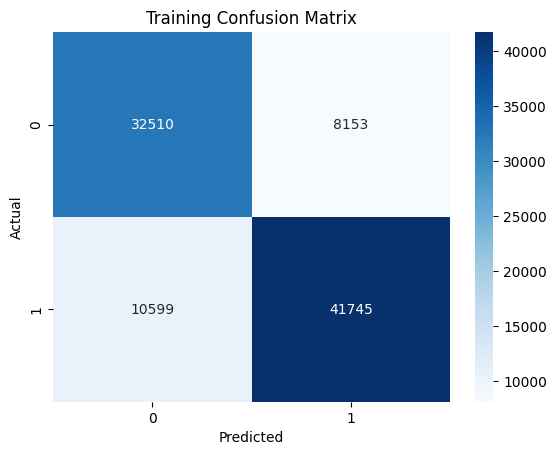

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Make predictions on training and testing sets
y_train_pred_xgb = bst.predict(dtrain)


# Convert probabilities to binary output
y_train_pred_xgb_bin = (y_train_pred_xgb > 0.5).astype(int)

# Evaluation on the training set
print("\nXGBoost Classifier (GPU) Training Results:")


print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_xgb_bin)}")
print(classification_report(y_train, y_train_pred_xgb_bin))
print("Training Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred_xgb_bin))

# Calculate individual metrics (precision, recall, f1-score) for training
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_train_pred_xgb_bin, average='binary')
print(f"Training Precision: {train_precision}")
print(f"Training Recall: {train_recall}")
print(f"Training F1-score: {train_f1}")

# Plot Confusion Matrix for training data
train_conf_matrix = confusion_matrix(y_train, y_train_pred_xgb_bin)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Training Confusion Matrix')
plt.show()

## Testing Report


Random Forest Classifier Results on the Testing Data:
Test Accuracy: 0.6968975550768999
              precision    recall  f1-score   support

           0       0.61      0.71      0.66     10903
           1       0.77      0.69      0.73     15560

    accuracy                           0.70     26463
   macro avg       0.69      0.70      0.69     26463
weighted avg       0.71      0.70      0.70     26463

Testing Confusion Matrix:
 [[ 7723  3180]
 [ 4841 10719]]
Testing Precision: 0.7712065616231384
Testing Recall: 0.6888817480719794
Testing F1-score: 0.7277232764180727


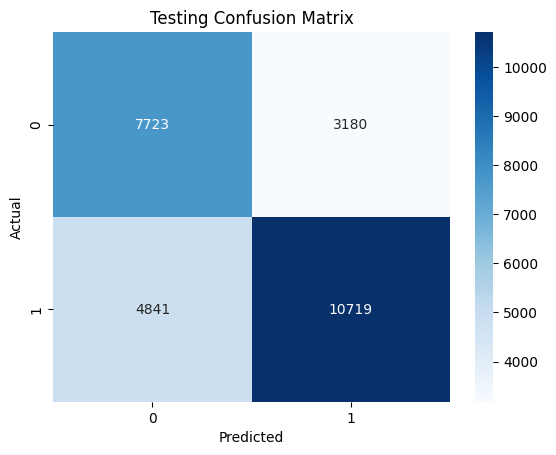

In [ ]:
import warnings
warnings.filterwarnings('ignore')

X_test_flat = X_test.reshape(X_test.shape[0], -1)
dtest = xgb.DMatrix(X_test_flat, label=y_test)




# Predict on the test data
y_test_pred_xgb = bst.predict(dtest)


y_test_pred_xgb_bin = (y_test_pred_xgb > 0.5).astype(int)

# Evaluate on Testing Data
print("\nRandom Forest Classifier Results on the Testing Data:")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred_xgb_bin)}")
print(classification_report(y_test, y_test_pred_xgb_bin))
print("Testing Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_xgb_bin))

# Calculate individual metrics (precision, recall, f1-score) for testing
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred_xgb_bin, average='binary')
print(f"Testing Precision: {test_precision}")
print(f"Testing Recall: {test_recall}")
print(f"Testing F1-score: {test_f1}")

# Plot Confusion Matrix for testing data
test_conf_matrix = confusion_matrix(y_test, y_test_pred_xgb_bin)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Testing Confusion Matrix')
plt.show()



# Misc

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report, confusion_matrix

# Convert probabilities to binary output
y_train_pred_xgb_bin = (y_train_pred_xgb > 0.5).astype(int)

# Evaluation on the training set
print("\nXGBoost Classifier (GPU) Training Results:")

# Accuracy for training
train_accuracy = accuracy_score(y_train, y_train_pred_xgb_bin)
print(f"Train Accuracy: {train_accuracy}")

# Precision, Recall, F1-score, and Support for training
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_train_pred_xgb_bin, average='binary')

print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1-score: {train_f1}")

# Detailed Classification Report for training
print("\nDetailed Training Classification Report:")
print(classification_report(y_train, y_train_pred_xgb_bin))

# Confusion Matrix for training
print("Training Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred_xgb_bin))

# ROC AUC Score for training
roc_auc_train = roc_auc_score(y_train, y_train_pred_xgb)
print(f"Training AUC: {roc_auc_train}\n")


XGBoost Classifier (GPU) Training Results:
Train Accuracy: 0.79838076703904
Train Precision: 0.8366066776223496
Train Recall: 0.7975126088950023
Train F1-score: 0.8165920071986073

Detailed Training Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78     40663
           1       0.84      0.80      0.82     52344

    accuracy                           0.80     93007
   macro avg       0.80      0.80      0.80     93007
weighted avg       0.80      0.80      0.80     93007

Training Confusion Matrix:
 [[32510  8153]
 [10599 41745]]
Training AUC: 0.8927319095945727



In [ ]:
X_test_flat = X_test.reshape(X_test.shape[0], -1)
# Make sure y_test matches the number of samples in X_test_flat
# if y_test.shape[0] != X_test_flat.shape[0]:
#     y_test = y_test[:X_test_flat.shape[0]]

# print(f"After adjustment: X_test_flat shape: {X_test_flat.shape}")
# print(f"After adjustment: y_test shape: {y_test.shape}")



dtest = xgb.DMatrix(X_test_flat, label=y_test)
y_test_pred_xgb = bst.predict(dtest)



y_test_pred_xgb_bin = (y_test_pred_xgb > 0.5).astype(int)

# Evaluation on the test set
print("\nXGBoost Classifier (GPU) Testing Results:")

# Accuracy for testing
test_accuracy = accuracy_score(y_test, y_test_pred_xgb_bin)
print(f"Test Accuracy: {test_accuracy}")

# Precision, Recall, F1-score, and Support for testing
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred_xgb_bin, average='binary')

print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1-score: {test_f1}")

# Detailed Classification Report for testing
print("\nDetailed Testing Classification Report:")
print(classification_report(y_test, y_test_pred_xgb_bin))

# Confusion Matrix for testing
print("Testing Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_xgb_bin))

# ROC AUC Score for testing
roc_auc_test = roc_auc_score(y_test, y_test_pred_xgb)
print(f"Testing AUC: {roc_auc_test}\n")


XGBoost Classifier (GPU) Testing Results:
Test Accuracy: 0.6968975550768999
Test Precision: 0.7712065616231384
Test Recall: 0.6888817480719794
Test F1-score: 0.7277232764180727

Detailed Testing Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.71      0.66     10903
           1       0.77      0.69      0.73     15560

    accuracy                           0.70     26463
   macro avg       0.69      0.70      0.69     26463
weighted avg       0.71      0.70      0.70     26463

Testing Confusion Matrix:
 [[ 7723  3180]
 [ 4841 10719]]
Testing AUC: 0.7673322500092543



In [ ]:
from sklearn.svm import SVC
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
# Initialize and train Support Vector Machine
svm_clf = SVC(kernel='rbf', probability=True)
svm_clf.fit(X_train_flat, y_train)

# Predict on training set
y_train_pred_svm = svm_clf.predict(X_train_flat)

# Evaluation on the training set
print("\nSupport Vector Machine (SVM) Training Results:")

# Accuracy for training
train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
print(f"Train Accuracy: {train_accuracy_svm}")

# Precision, Recall, F1-score, and Support for training
train_precision_svm, train_recall_svm, train_f1_svm, _ = precision_recall_fscore_support(y_train, y_train_pred_svm, average='binary')

print(f"Train Precision: {train_precision_svm}")
print(f"Train Recall: {train_recall_svm}")
print(f"Train F1-score: {train_f1_svm}")

# Detailed Classification Report for training
print("\nDetailed Training Classification Report:")
print(classification_report(y_train, y_train_pred_svm))

# Confusion Matrix for training
print("Training Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred_svm))


In [ ]:
# Apply Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_val)
print("\nDecision Tree Classifier Results:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_dt)}")
print(classification_report(y_val, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_dt))



# # Evaluate on the test set
# y_test_pred_dt = dt_clf.predict(X_test)

# print("\nDecision Tree Test Results:")
# print(f"Accuracy: {accuracy_score(y_test, y_test_pred_dt)}")
# print(classification_report(y_test, y_test_pred_dt))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_dt))







# from sklearn.model_selection import GridSearchCV
# from sklearn.tree import DecisionTreeClassifier

# # Define parameter grid for tuning
# param_grid = {
#     'max_depth': [5, 10, 15, 20, None],
#     'min_samples_split': [2, 10, 20],
#     'min_samples_leaf': [1, 5, 10],
#     'max_features': [None, 'sqrt', 'log2']
# }

# # Set up the grid search with cross-validation
# grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# # Best estimator after tuning
# best_dt_clf = grid_search.best_estimator_
# print(f"Best Parameters: {grid_search.best_params_}")

# # Train with the best model and validate
# best_dt_clf.fit(X_train, y_train)
# y_pred_dt = best_dt_clf.predict(X_val)

# # Validation results
# print("\nDecision Tree Classifier Results After Tuning:")
# print(f"Accuracy: {accuracy_score(y_val, y_pred_dt)}")
# print(classification_report(y_val, y_pred_dt))
# print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_dt))

# # Evaluate on the test set
# y_test_pred_dt = best_dt_clf.predict(X_test)
# print("\nDecision Tree Test Results After Tuning:")
# print(f"Accuracy: {accuracy_score(y_test, y_test_pred_dt)}")
# print(classification_report(y_test, y_test_pred_dt))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_dt))


ValueError: Found array with dim 3. DecisionTreeClassifier expected <= 2.

In [ ]:


from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define parameter grid for tuning
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best estimator after tuning
best_dt_clf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Train with the best model and validate
best_dt_clf.fit(X_train, y_train)
y_pred_dt = best_dt_clf.predict(X_val)

# Validation results
print("\nDecision Tree Classifier Results After Tuning:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_dt)}")
print(classification_report(y_val, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_dt))

# Evaluate on the test set
y_test_pred_dt = best_dt_clf.predict(X_test)
print("\nDecision Tree Test Results After Tuning:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_dt)}")
print(classification_report(y_test, y_test_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_dt))


KeyboardInterrupt: 

In [ ]:


# Apply Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_val)
print("\nRandom Forest Classifier Results:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_rf)}")
print(classification_report(y_val, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_rf))





Random Forest Classifier Results:
Accuracy: 0.93579809608147
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2293
           1       0.93      0.94      0.94      2224

    accuracy                           0.94      4517
   macro avg       0.94      0.94      0.94      4517
weighted avg       0.94      0.94      0.94      4517

Confusion Matrix:
 [[2138  155]
 [ 135 2089]]


In [ ]:
# Evaluate on the test set
y_test_pred_dt = dt_clf.predict(X_test)
y_test_pred_rf = rf_clf.predict(X_test)

print("\nDecision Tree Test Results:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_dt)}")
print(classification_report(y_test, y_test_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_dt))

print("\nRandom Forest Test Results:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_rf)}")
print(classification_report(y_test, y_test_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_rf))


Decision Tree Test Results:
Accuracy: 0.5304074425015074
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10903
           1       0.53      1.00      0.69     12315

    accuracy                           0.53     23218
   macro avg       0.27      0.50      0.35     23218
weighted avg       0.28      0.53      0.37     23218

Confusion Matrix:
 [[    0 10903]
 [    0 12315]]

Random Forest Test Results:
Accuracy: 0.5304074425015074
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10903
           1       0.53      1.00      0.69     12315

    accuracy                           0.53     23218
   macro avg       0.27      0.50      0.35     23218
weighted avg       0.28      0.53      0.37     23218

Confusion Matrix:
 [[    0 10903]
 [    0 12315]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
y_pred_prob_rf = y_test_pred_dt

# Calculate various metrics
accuracy = accuracy_score(y_test, y_pred_prob_rf)
precision = precision_score(y_test, y_pred_prob_rf)
recall = recall_score(y_test, y_pred_prob_rf)
f1 = f1_score(y_test, y_pred_prob_rf)
roc_auc = roc_auc_score(y_test, y_pred_prob_rf)
mcc = matthews_corrcoef(y_test, y_pred_prob_rf)

# Print the results
print("\nDecision Tree Classifier Results:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Matthews Correlation Coefficient (MCC): {mcc}")
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_dt))

# Optional: print detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_dt))


Decision Tree Classifier Results:
Accuracy: 0.5304074425015074
Precision: 0.5304074425015074
Recall: 1.0
F1-Score: 0.6931584724059325
ROC AUC: 0.5
Matthews Correlation Coefficient (MCC): 0.0
Confusion Matrix:
 [[1927  366]
 [ 303 1921]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      2293
           1       0.84      0.86      0.85      2224

    accuracy                           0.85      4517
   macro avg       0.85      0.85      0.85      4517
weighted avg       0.85      0.85      0.85      4517



In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_curve, auc
import matplotlib as plt
# Apply Random Forest Classifier


# y_test_pred_rf = rf_clf.predict(X_test)

y_pred_prob_rf = y_test_pred_rf
# Print all relevant scores
accuracy = accuracy_score(y_test, y_test_pred_rf)
precision = precision_score(y_test, y_test_pred_rf)
recall = recall_score(y_test, y_test_pred_rf)
f1 = f1_score(y_test, y_test_pred_rf)
roc_auc = roc_auc_score(y_test, y_test_pred_rf)
mcc = matthews_corrcoef(y_test, y_test_pred_rf)

# Print the results
print("\nRandom Forest Classifier Results:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Matthews Correlation Coefficient (MCC): {mcc}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_rf))

# Optional: print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_rf))





Random Forest Classifier Results:
Accuracy: 0.5304074425015074
Precision: 0.5304074425015074
Recall: 1.0
F1-Score: 0.6931584724059325
ROC AUC: 0.5
Matthews Correlation Coefficient (MCC): 0.0
Confusion Matrix:
 [[    0 10903]
 [    0 12315]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10903
           1       0.53      1.00      0.69     12315

    accuracy                           0.53     23218
   macro avg       0.27      0.50      0.35     23218
weighted avg       0.28      0.53      0.37     23218



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


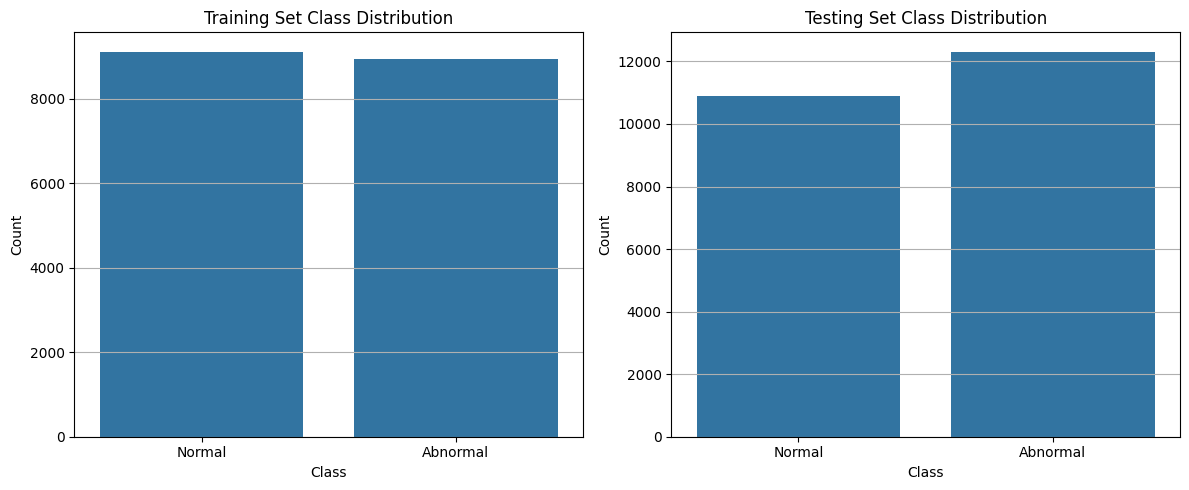

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Checking class distribution
def plot_class_distribution(y_train, y_test):
    plt.figure(figsize=(12, 5))

    # Training set distribution
    plt.subplot(1, 2, 1)
    sns.countplot(x=y_train)
    plt.title('Training Set Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Normal', 'Abnormal'])
    plt.grid(axis='y')

    # Testing set distribution
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_test)
    plt.title('Testing Set Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Normal', 'Abnormal'])
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

# Example usage
plot_class_distribution(y_train, y_test)


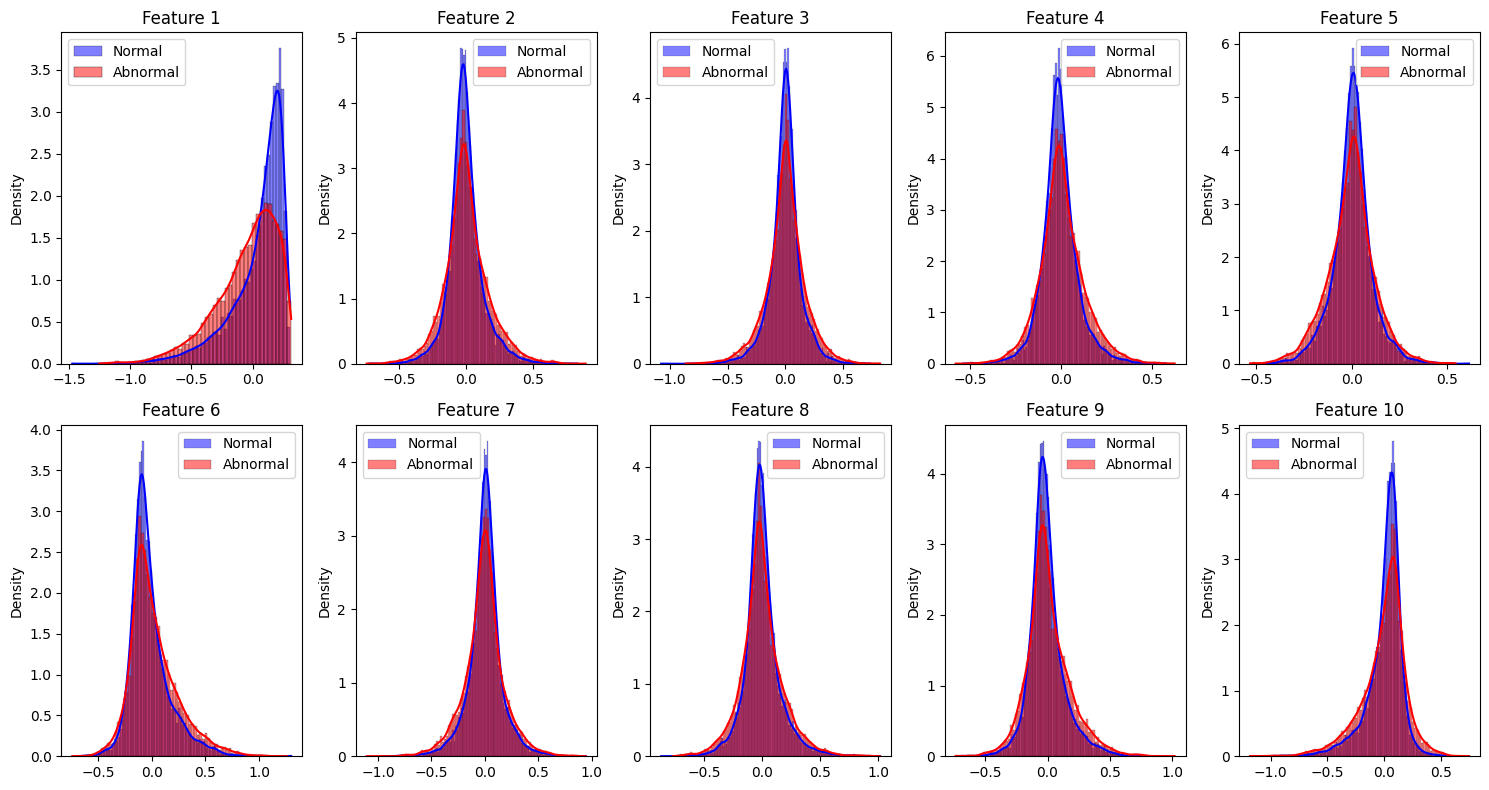

In [ ]:
# Analyzing the first few features
def plot_feature_distributions(X, y, feature_names=None, n_features=10):
    """Plot distributions of the first n features for both classes."""
    plt.figure(figsize=(15, 8))

    for i in range(min(n_features, X.shape[1])):
        plt.subplot(2, 5, i + 1)
        sns.histplot(X[y == 0, i], color='blue', label='Normal', kde=True, stat='density')
        sns.histplot(X[y == 1, i], color='red', label='Abnormal', kde=True, stat='density')
        plt.title(f'Feature {i + 1}' if not feature_names else feature_names[i])
        plt.xlabel('')
        plt.ylabel('Density')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_feature_distributions(X_train, y_train, n_features=10)


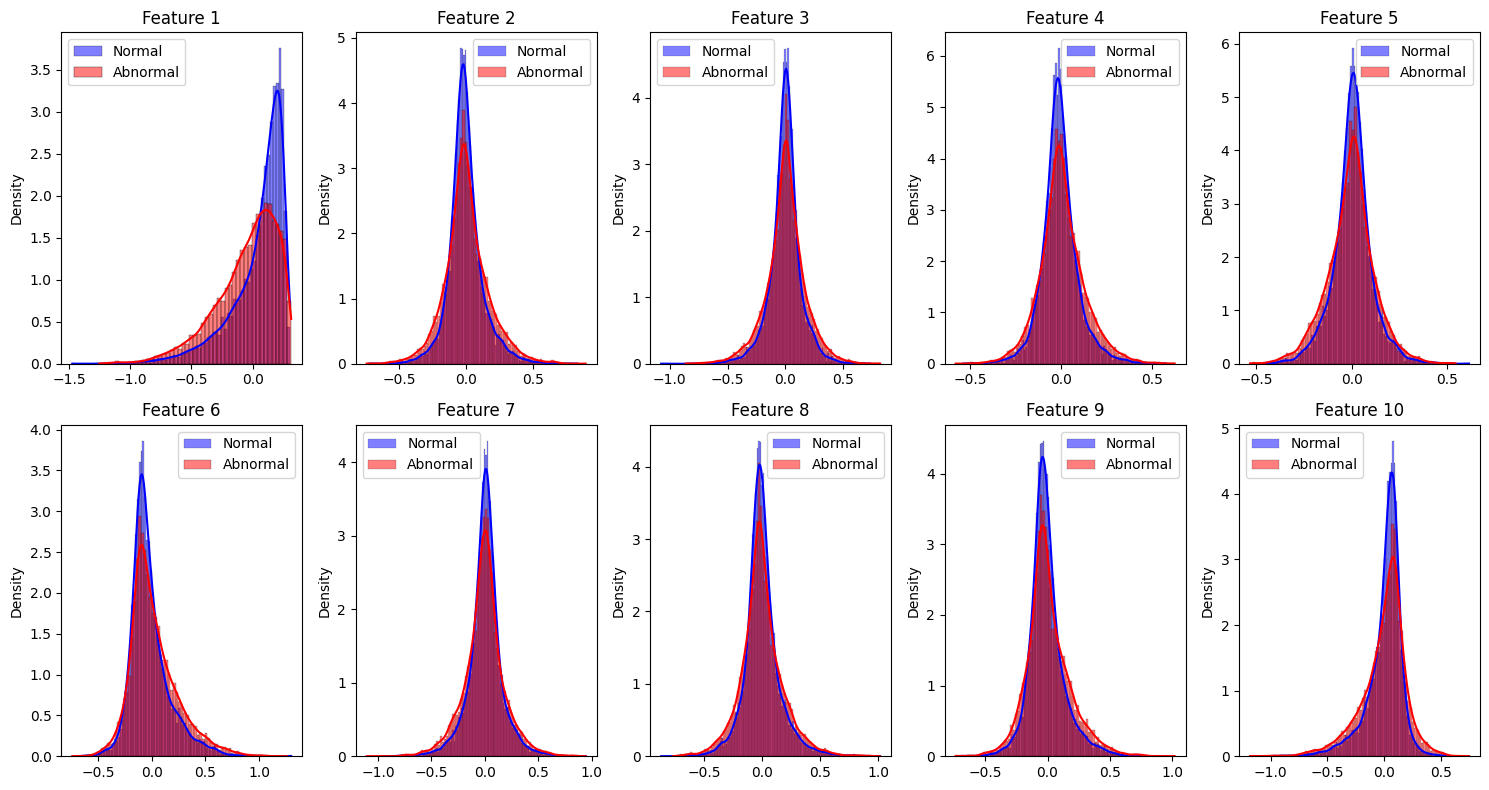

In [ ]:
# Analyzing the first few features
def plot_feature_distributions(X, y, feature_names=None, n_features=10):
    """Plot distributions of the first n features for both classes."""
    plt.figure(figsize=(15, 8))

    for i in range(min(n_features, X.shape[1])):
        plt.subplot(2, 5, i + 1)
        sns.histplot(X[y == 0, i], color='blue', label='Normal', kde=True, stat='density')
        sns.histplot(X[y == 1, i], color='red', label='Abnormal', kde=True, stat='density')
        plt.title(f'Feature {i + 1}' if not feature_names else feature_names[i])
        plt.xlabel('')
        plt.ylabel('Density')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_feature_distributions(X_train, y_train, n_features=10)


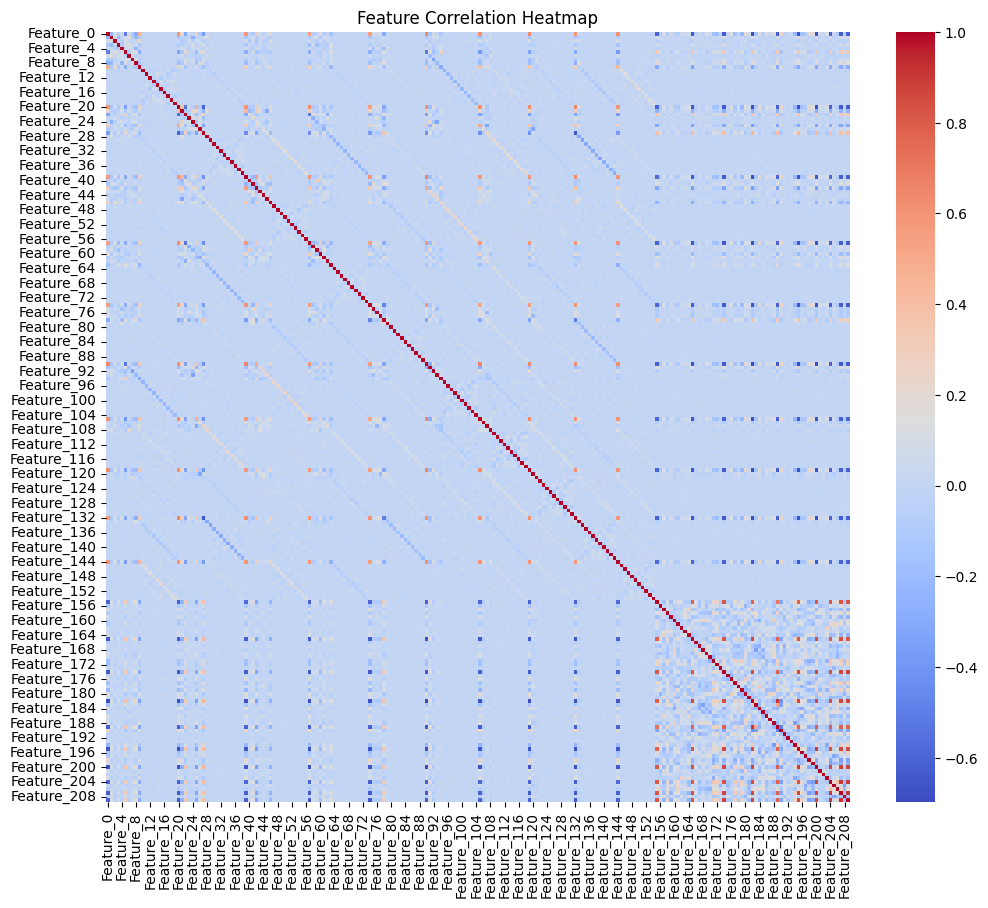

In [ ]:
import pandas as pd

# Convert training data into a DataFrame for correlation analysis
X_train_df = pd.DataFrame(X_train, columns=[f'Feature_{i}' for i in range(X_train.shape[1])])

# Compute correlation matrix
correlation_matrix = X_train_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f', cbar=True)
plt.title('Feature Correlation Heatmap')
plt.show()


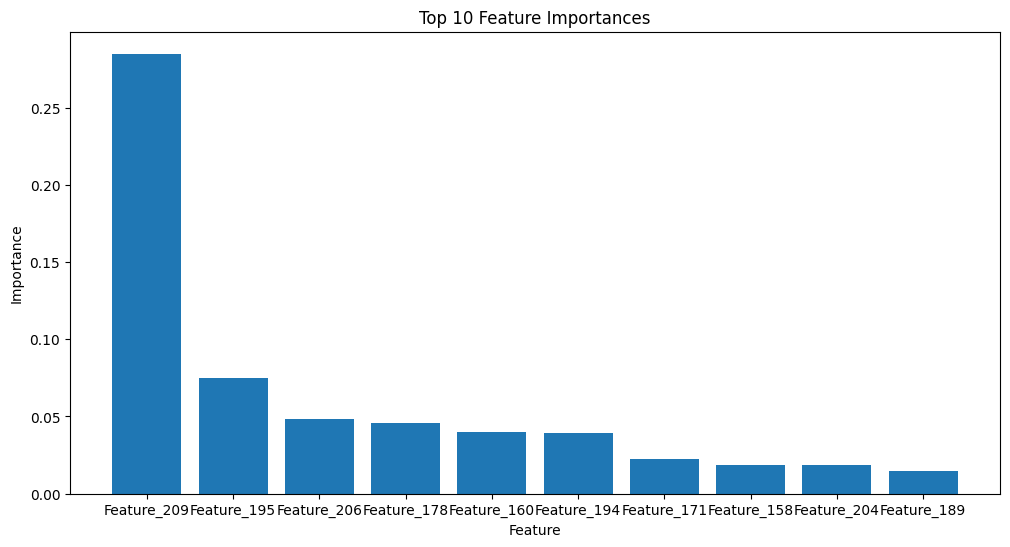

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Fit a Decision Tree to get feature importance
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Get feature importance
feature_importance = dt_clf.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(10), feature_importance[sorted_idx[:10]], align='center')
plt.xticks(range(10), [f'Feature_{i}' for i in sorted_idx[:10]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.show()


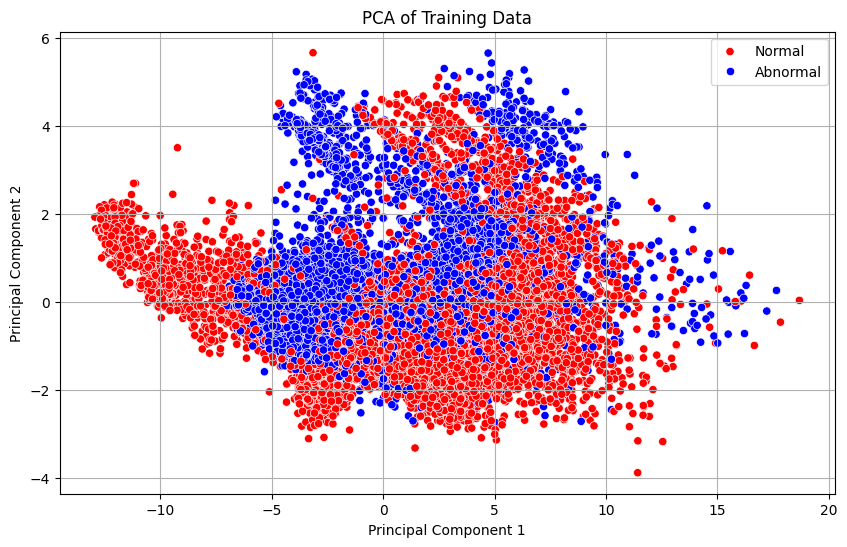

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette=['blue', 'red'])
plt.title('PCA of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(['Normal', 'Abnormal'])
plt.grid(True)
plt.show()


In [ ]:
raw = mne.io.read_raw_edf('/content/drive/MyDrive/Alternative_Scalp_EEG_Dataset/Traindata/Normal/0000024.edf', preload=True)
n_time_samps = raw.n_times
time_secs = raw.times
ch_names = raw.ch_names
n_chan = len(ch_names)  # note: there is no raw.n_channels attribute
print(
    "the (cropped) sample data object has {} time samples and {} channels."
    "".format(n_time_samps, n_chan)
)
print("The last time sample is at {} seconds.".format(time_secs[-1]))
print("The first few channel names are {}.".format(", ".join(ch_names)))
print()  # insert a blank line in the output

# some examples of raw.info:
print("bad channels:", raw.info["bads"])  # chs marked "bad" during acquisition
print(raw.info["sfreq"], "Hz")  # sampling frequency
print(raw.info["description"], "\n")  # miscellaneous acquisition info

print(raw.info)


Extracting EDF parameters from /content/drive/MyDrive/Alternative_Scalp_EEG_Dataset/Traindata/Normal/0000024.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 134399  =      0.000 ...   671.995 secs...
the (cropped) sample data object has 134400 time samples and 21 channels.
The last time sample is at 671.995 seconds.
The first few channel names are FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, T6, FZ, PZ, CZ, A1, A2.

bad channels: []
200.0 Hz
None 

<Info | 8 non-empty values
 bads: []
 ch_names: FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2021-04-10 15:47:05 UTC
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 4 items (dict)
>


In [ ]:
data, times = raw.get_data(return_times=True)
print(data.shape)
print(times.shape)

(21, 134400)
(134400,)


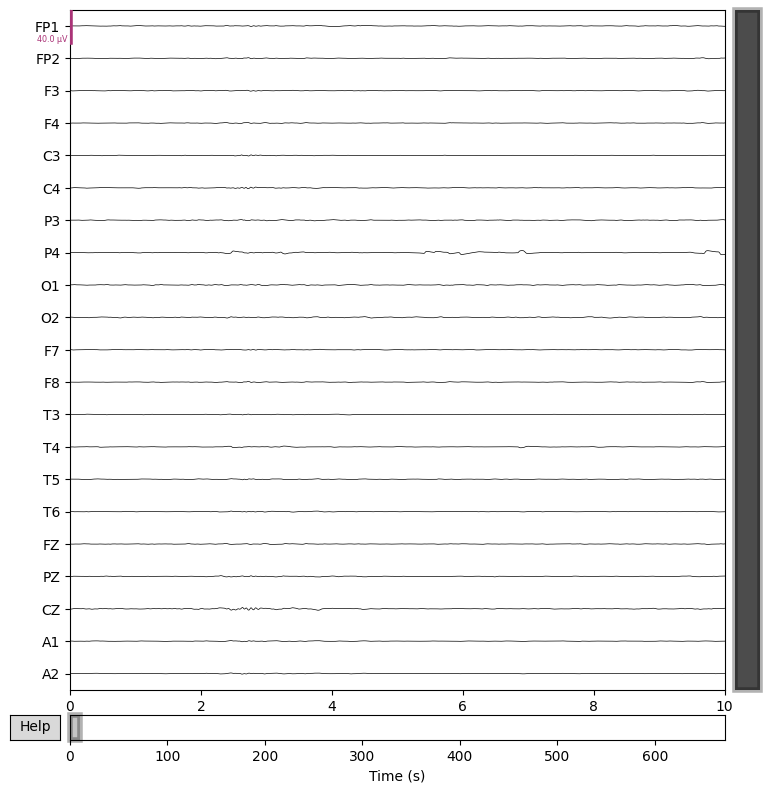

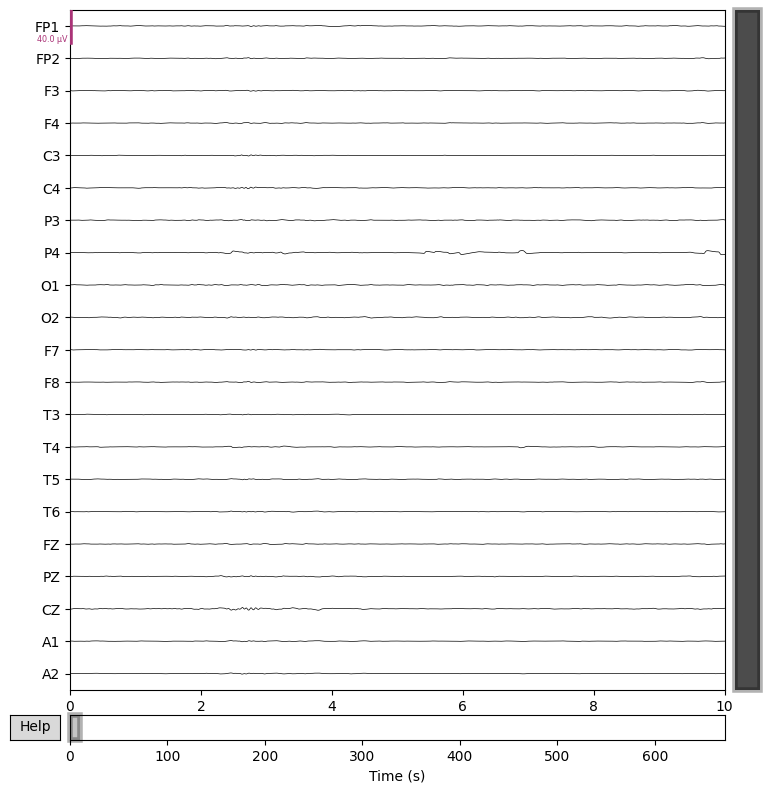

In [ ]:
raw.plot(n_channels=21)

Data shape: (21, 134400)
Channel names: ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'PZ', 'CZ', 'A1', 'A2']
Sampling frequency: 200.0 Hz
Effective window size : 10.240 (s)


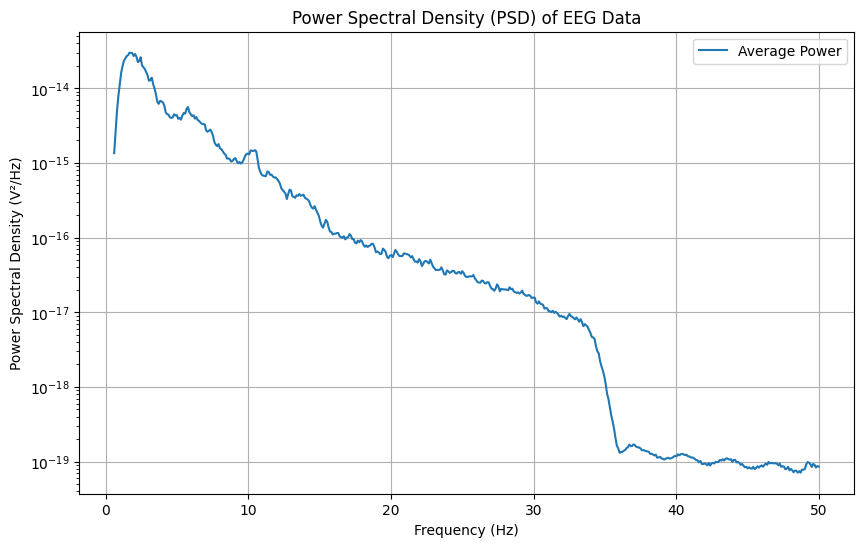

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).


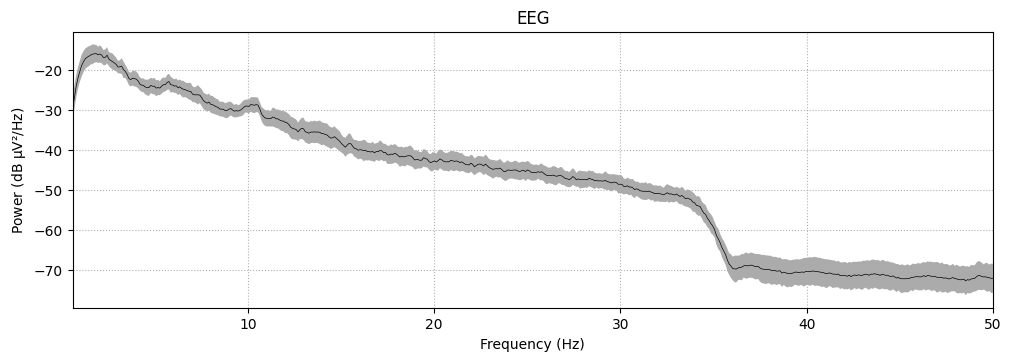

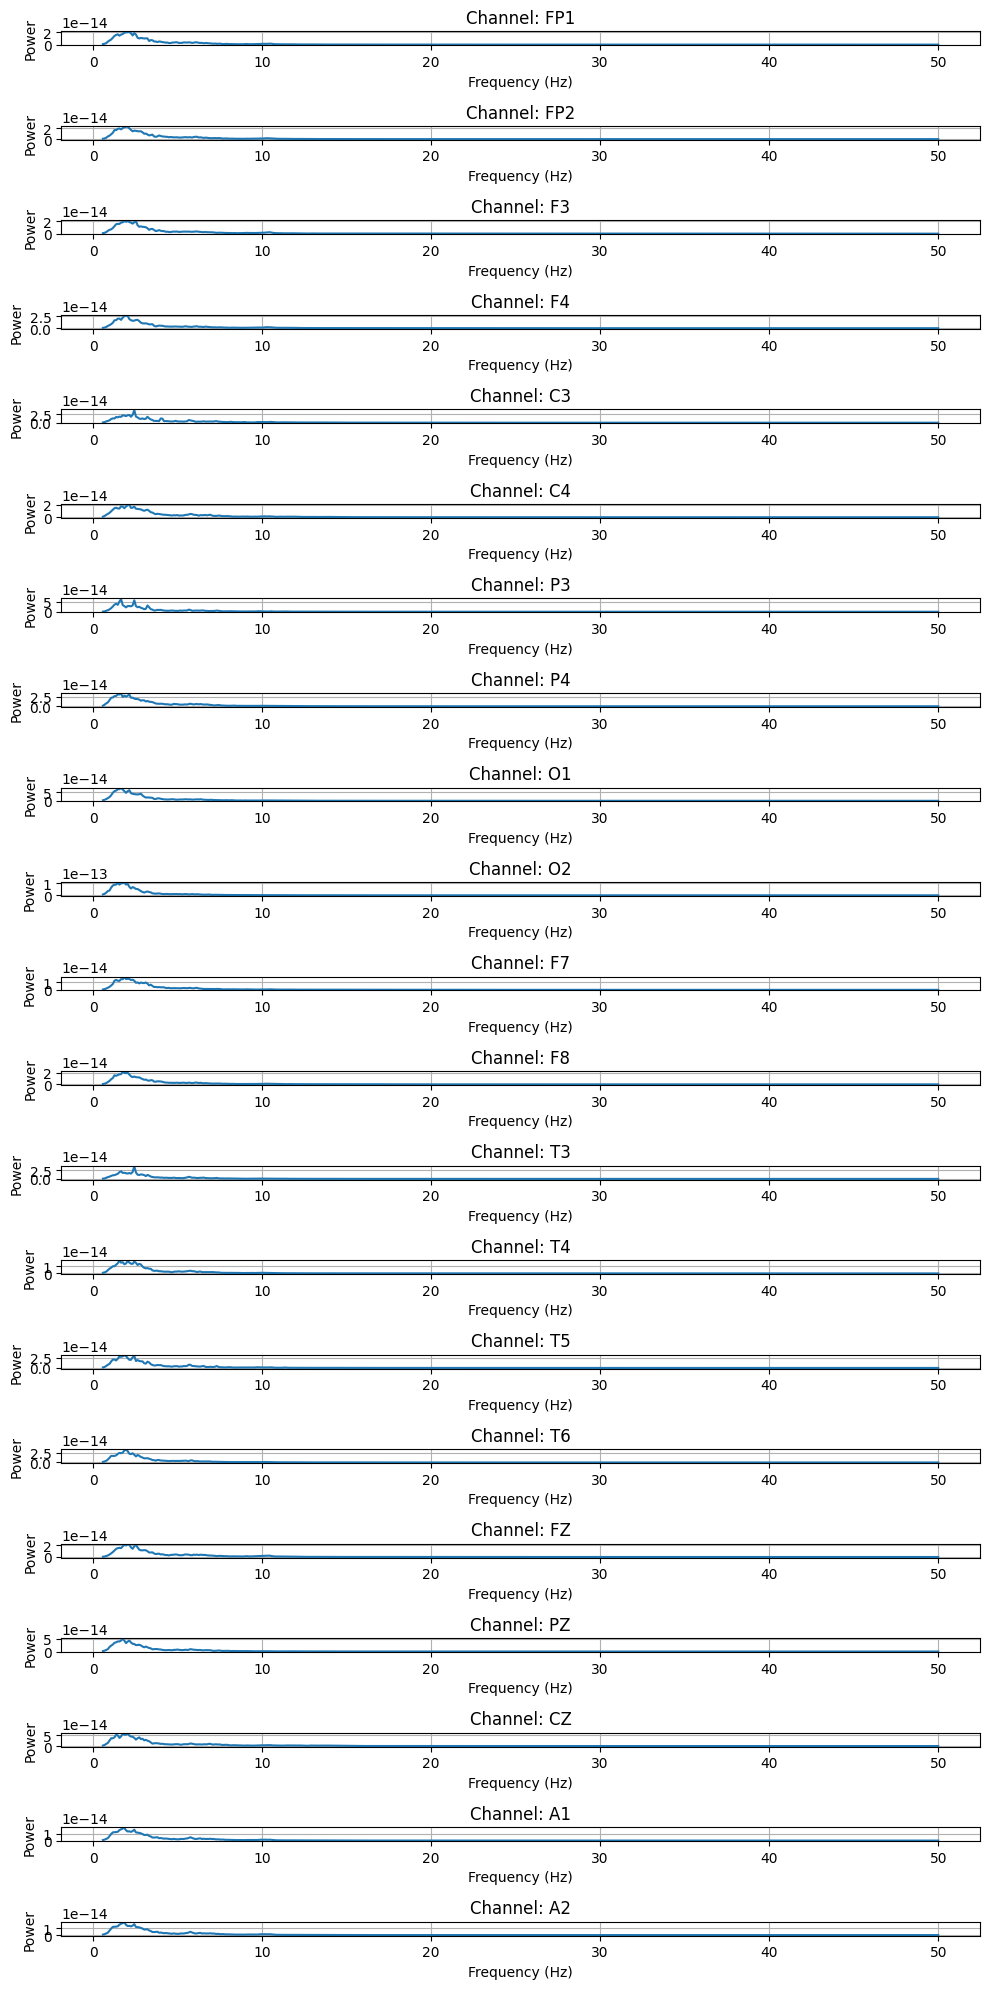

In [ ]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt

# Define the path to the .edf file
file_path = "/content/drive/MyDrive/Alternative_Scalp_EEG_Dataset/Traindata/Normal/0000024.edf"

# Load the .edf file using MNE
raw = mne.io.read_raw_edf(file_path, preload=True, verbose='error')

# Display basic information about the data
print(f"Data shape: {raw.get_data().shape}")
print(f"Channel names: {raw.ch_names}")
print(f"Sampling frequency: {raw.info['sfreq']} Hz")

# Compute the Power Spectral Density (PSD) for the data
psd, freqs = raw.compute_psd(method='welch', fmin=0.5, fmax=50, n_fft=2048).get_data(return_freqs=True)

# Plot the average power spectrum across all channels
plt.figure(figsize=(10, 6))
plt.semilogy(freqs, np.mean(psd, axis=0), label='Average Power')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V²/Hz)')
plt.title('Power Spectral Density (PSD) of EEG Data')
plt.grid(True)
plt.legend()
plt.show()

# Plot PSD for each channel individually
raw.plot_psd(fmin=0.5, fmax=50, average=True)

# Create subplots for each channel and frequency component visualization
fig, axes = plt.subplots(nrows=len(raw.ch_names), figsize=(10, 20))
for i, ch_name in enumerate(raw.ch_names):
    # Plot power spectrum for each channel
    axes[i].plot(freqs, psd[i])
    axes[i].set_title(f'Channel: {ch_name}')
    axes[i].set_ylabel('Power')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].grid(True)

plt.tight_layout()
plt.show()


Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).
Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).
Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).


<ipython-input-24-b0747f260a1a>:12: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum.plot(average=False, picks="data", exclude="bads", show=False)
<ipython-input-24-b0747f260a1a>:12: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum.plot(average=False, picks="data", exclude="bads", show=False)


Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).
Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).


<ipython-input-24-b0747f260a1a>:12: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum.plot(average=False, picks="data", exclude="bads", show=False)
<ipython-input-24-b0747f260a1a>:12: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum.plot(average=False, picks="data", exclude="bads", show=False)
<ipython-input-24-b0747f260a1a>:12: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum.plot(average=False, picks="data", exclude="bads", show=False)


IndexError: All picks must be < n_channels (21), got [20, 21, 22, 23]

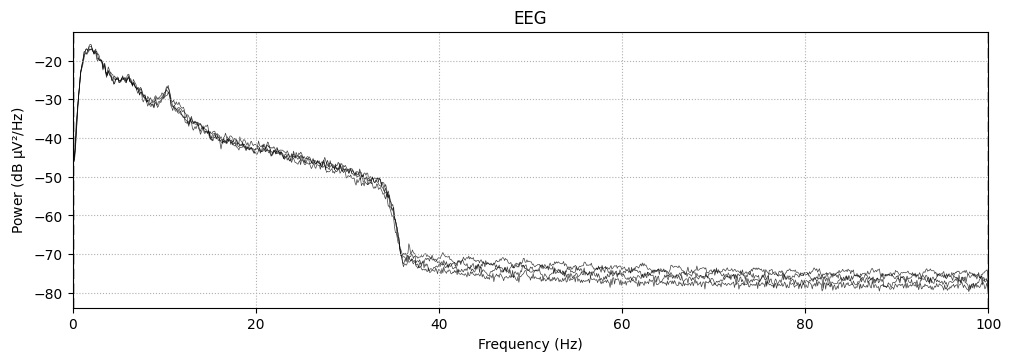

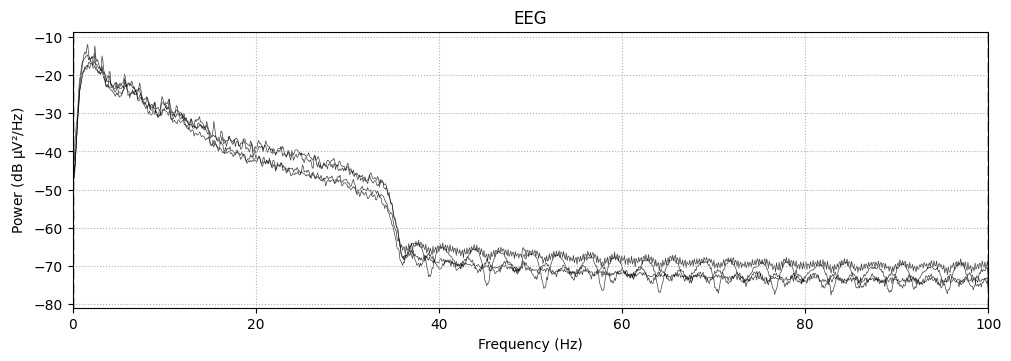

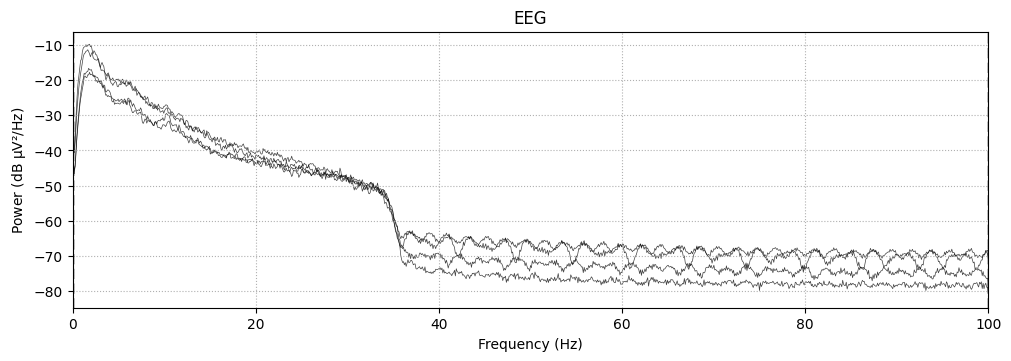

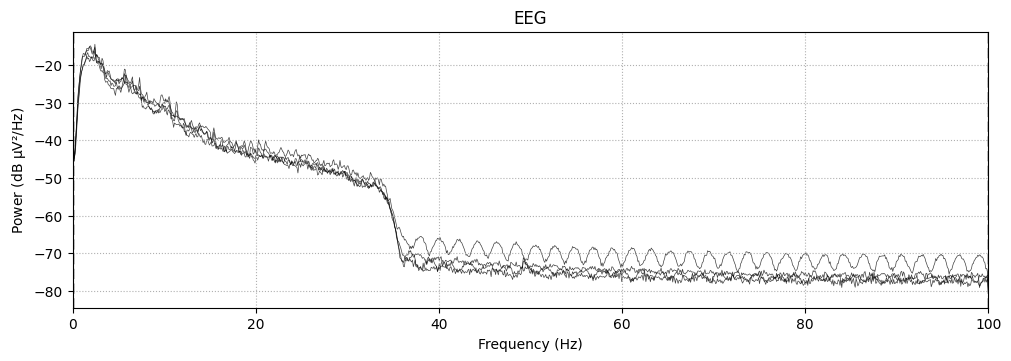

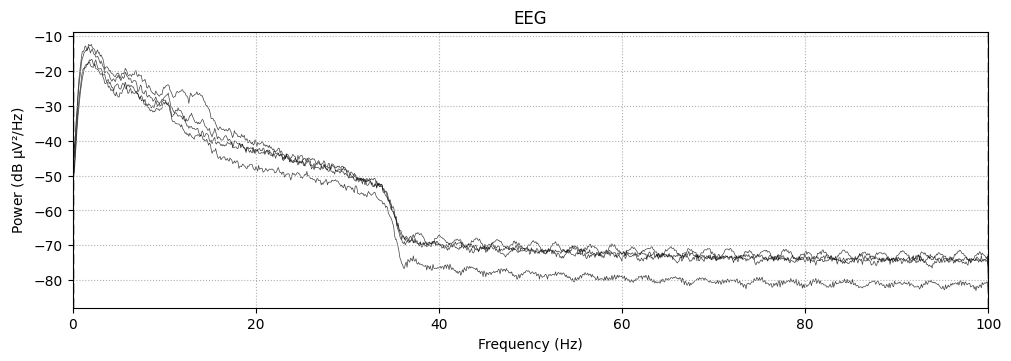

In [ ]:
from matplotlib.lines import Line2D
# Get the list of channel names
channel_names = raw.ch_names

# Iterate over each channel
for i in range(0,len(channel_names),4):

    # Select the channel and compute the power spectrum
    channel_data = raw.copy().pick([i,i+1,i+2,i+3])
    spectrum = channel_data.compute_psd()
    # Plot the power spectrum
    spectrum.plot(average=False, picks="data", exclude="bads", show=False)

# Show the plot
plt.show()

Fitting ICA to data using 21 channels (please be patient, this may take a while)


<ipython-input-27-a40fbbc42e8e>:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 21 components
Fitting ICA took 15.7s.
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 0 ICA components
    Projecting back using 21 PCA components


<ipython-input-27-a40fbbc42e8e>:3: RuntimeWarning: Using n_components=21 (resulting in n_components_=21) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.4) and smallest (1.9e-11) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 20
  ica.fit(raw)


Creating RawArray with float64 data, n_channels=16, n_times=134400
    Range : 0 ... 134399 =      0.000 ...   671.995 secs
Ready.


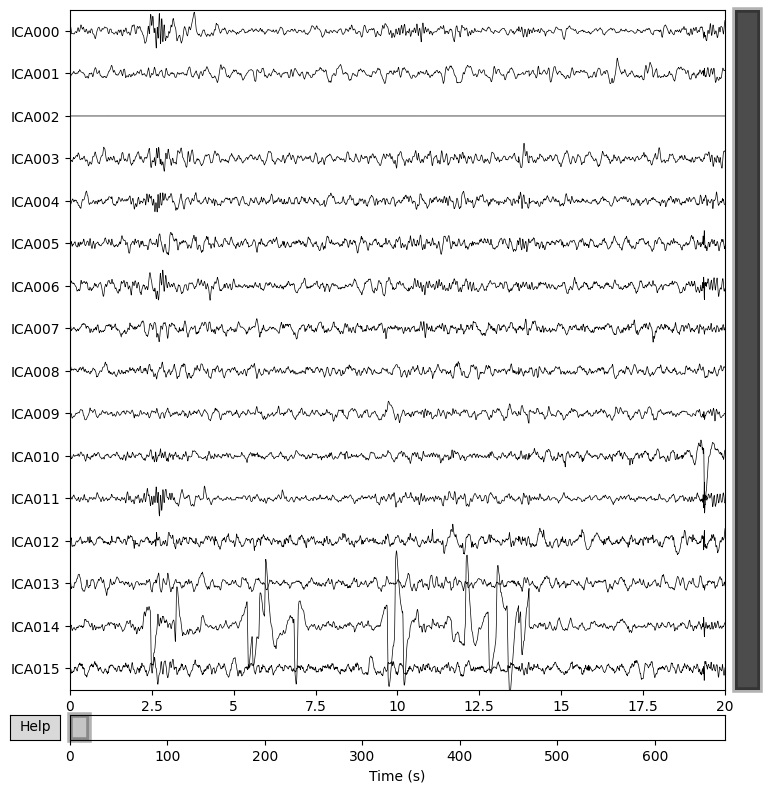

IndexError: All picks must be < n_components (21), got range(16, 32)

In [ ]:
from mne.preprocessing import ICA
ica = ICA(n_components=21, max_iter="auto", random_state=97)
ica.fit(raw)
ica.apply(raw)

raw.load_data()
ica.plot_sources(raw, picks=range(16))
ica.plot_sources(raw, picks=range(16,32))
ica.plot_sources(raw, picks=range(32,48))
ica.plot_sources(raw, picks=range(48,63))

In [ ]:
#values range between 0 and 1, 0 being black and 1 being white

# Create subplots for each frequency
fig, axes = plt.subplots(nrows=len(freqs), ncols=1, figsize=(10, 300))

im = None

# Iterate over frequencies
for i, freq in enumerate(freqs):
    # Get the power data for the current frequency
    freq_data = power_data[:, i, :]

    # Plot the power data
    axes[i].imshow(freq_data, aspect='auto', origin='lower', cmap='gray')

    # Set the y-axis label
    axes[i].set_ylabel('Epochs')

    # Set the title
    axes[i].set_title(f'Frequency: {freq} Hz')


# Set the x-axis label for the last subplot
axes[-1].set_xlabel('Time')

plt.tight_layout()

# Show the plot
plt.show()

NameError: name 'power_data' is not defined